##***Mounting Drive and Loading Data***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

admission_df = pd.read_csv('/content/drive/MyDrive/Job Hunt/hospital/Admissions.csv')
lab_df = pd.read_csv('/content/drive/MyDrive/Job Hunt/hospital/Lab.csv')
transfusion_df = pd.read_csv('/content/drive/MyDrive/Job Hunt/hospital/Transfusions.csv')

admission_df.head(2)

,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score
0,3602,34208,2011-09-07,NaN,09/11/2011,13:16,St. Joseph's Health Centre,NaN,M,1,45
1,2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,M,1,46


In [4]:
lab_df.head(2)

,admission_id,test_name,test_code,result_unit,result_value,result_date,result_time
0,4416,Albumin,ALB,g/dL,4.1,2003-08-19,02:25
1,4636,Platelet Count,PLT,E9/L,295.0,2012-02-05,01:42


In [5]:
transfusion_df.head(2)

,admission_id,issue_date,issue_time,rbc_transfusion,platelet_transfusion,plasma_transfusion
0,8755,2002-08-25,16:05,False,False,True
1,9736,2006-03-17,08:05,True,False,False


##***Combining all three data frames using admission_id into one dataframe, retaining all rows from Admissions***

In [13]:
combined_df = admission_df.merge(lab_df, on='admission_id', how='left').merge(transfusion_df,
                                                                              on='admission_id', how = 'left')
print(admission_df.shape)
print(combined_df.shape)
combined_df.head(2)

(5231, 11)
(5231, 22)


,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score,test_name,test_code,result_unit,result_value,result_date,result_time,issue_date,issue_time,rbc_transfusion,platelet_transfusion,plasma_transfusion
0,3602,34208,2011-09-07,NaN,09/11/2011,13:16,St. Joseph's Health Centre,NaN,M,1,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,M,1,46,Albumin,ALB,g/dL,2.2,2008-07-22,16:45,NaN,NaN,NaN,NaN,NaN


In order to keep all the rows of the admissions we will left join the admission table with lab table and left join the resulting table with the transfusion table

##***Finding Missing Values in Each Feature***

In [66]:
missing_values = combined_df.isnull().sum()
missing_values

admission_id                     0
patient_id                       0
admission_date                   0
admission_time                 696
discharge_date                   0
discharge_time                   0
hospital                         0
age                            627
sex                              0
charlson_comorbidity_index     261
lap_score                        0
test_name                     1622
test_code                     1622
result_unit                   1622
result_value                  1622
result_date                   1622
result_time                   1622
issue_date                    4574
issue_time                    4574
rbc_transfusion               4574
platelet_transfusion          4574
plasma_transfusion            4574
age_with_mean                    0
age_with_cc                    261
dtype: int64

##***Imputing Missing Values in DataSet***

In [30]:
combined_df_no_nan = combined_df.dropna()
mean_value_age=int(combined_df_no_nan['age'].mean())

mode_value_cc_ind=combined_df_no_nan['charlson_comorbidity_index'].mode()
combined_df['age_with_mean']=combined_df['age'].fillna(mean_value_age)
combined_df['age_with_cc']=combined_df['charlson_comorbidity_index'].fillna(mode_value_cc_ind)

combined_df.head(2)


,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score,test_name,test_code,result_unit,result_value,result_date,result_time,issue_date,issue_time,rbc_transfusion,platelet_transfusion,plasma_transfusion,age_with_mean,age_with_cc
0,3602,34208,2011-09-07,NaN,09/11/2011,13:16,St. Joseph's Health Centre,NaN,M,1,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,1
1,2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,M,1,46,Albumin,ALB,g/dL,2.2,2008-07-22,16:45,NaN,NaN,NaN,NaN,NaN,48.0,1


This is the most common method of data imputation, where you just replace all the missing values with the mean, median or mode of the column. While this is useful it’s easy and fast, it sometimes changes the statistical nature of the data. It may result in skewness histograms. Secondly it will underestimate the variance in our data because we’re making numerous values the exact same.

However, its better to impute mean value in age and mode value in charlson_comorbidity_index column. All values in charlson_comorbidity_index column are not numbers so mean and median are not possible.

There are 600+ empty rows so we cannot remove them as a lot of data will be lost.

##***Hypothesis Testing :***
###***Is there a significant difference in age between patients who had an RBC transfusion and patients that did not ?***

Assumptions

Observations in each sample are independent and identically distributed (iid).
Observations in each sample are normally distributed as per Central Limit Theorem(samples = 5231 > 30).
Observations in each sample have the same variance.
Interpretation

H0: the means of the samples are equal.
H1: the means of the samples are unequal.



In [47]:
combined_df_hyp = combined_df.copy()
combined_df_hyp = combined_df_hyp[combined_df_hyp['rbc_transfusion'].notna()]
combined_df_true = list(combined_df_hyp[combined_df_hyp['rbc_transfusion']==True]['age_with_mean'])
combined_df_false = list(combined_df_hyp[combined_df_hyp['rbc_transfusion']==False]['age_with_mean'])

In [48]:
from scipy.stats import ttest_ind

stat, p = ttest_ind(combined_df_true, combined_df_false)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')
 
print("P-value",p)
print("Mean of rbc tranfusion true: ",sum(combined_df_true)/len(combined_df_true))
print("Mean of rbc tranfusion false: ",sum(combined_df_false)/len(combined_df_false))


stat=7.707, p=0.000
Probably different distributions
P-value 4.784227046802278e-14
Mean of rbc tranfusion true:  57.8563829787234
Mean of rbc tranfusion false:  55.15658362989324


In [50]:
combined_df_hyp.shape

(657, 24)

##***Hypothesis Testing of proportion-based samples:***
###***Is a significant difference in sex between the groups who had an RBC transfusion and those who did not ?***

In [84]:
combined_rbc_true = combined_df_hyp[combined_df_hyp['rbc_transfusion']==True]
combined_obs  = combined_rbc_true.shape[0]
combined_male = combined_rbc_true[combined_rbc_true['sex']=='M'].shape[0]
combined_female = combined_rbc_true[combined_rbc_true['sex']=='F'].shape[0]


print(combined_obs)
print(combined_male)
print(combined_female)

376
167
209


In [86]:
combined_rbc_false = combined_df_hyp[combined_df_hyp['rbc_transfusion']==False]
combined_obs_false  = combined_rbc_false.shape[0]
combined_male_false = combined_rbc_false[combined_rbc_false['sex']=='M'].shape[0]
combined_female_false = combined_rbc_false[combined_rbc_false['sex']=='F'].shape[0]


print(combined_obs_false)
print(combined_male_false)
print(combined_female_false)

281
112
169


In [92]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
count_male = np.array([combined_male, combined_male_false])
nobs = np.array([combined_obs, combined_obs_false])
stat, pval = proportions_ztest(count_male, nobs,0.05)
print('{0:0.3f}'.format(pval))

0.910
Probably the same distribution


In [93]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
count_female = np.array([combined_female, combined_female_false])
nobs = np.array([combined_obs, combined_obs_false])
stat, pval = proportions_ztest(count_female, nobs,0.05)
print('{0:0.3f}'.format(pval))

if pval > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')
 


0.014
Probably different distributions


We can observe 0.014 is less than 0.05 therefore there is a difference between sex propotions in both the groups

##***Linear regression model***
###***Using the result_value of the “Platelet Count” lab tests as the dependent variable and age, sex, and hospital as the independent variables***

In [78]:
combined_df_reg = combined_df.copy()
combined_df_reg = combined_df_reg
combined_df_reg = combined_df_reg[combined_df_reg['test_name']=='Platelet Count']

X = combined_df_reg[['age_with_mean','sex','hospital']]
X = pd.get_dummies(data=X, drop_first=True)
Y = combined_df_reg['result_value']
X.head(5)

,age_with_mean,sex_M,hospital_St. Joseph's Health Centre,hospital_St. Michael's Hospital,hospital_Sunnybrook Health Sciences Centre,hospital_Toronto Western Hospital
7,52.0,0,1,0,0,0
8,56.0,0,0,1,0,0
18,56.0,0,0,1,0,0
43,56.0,1,0,0,1,0
44,58.0,0,0,0,1,0


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = LinearRegression()
model.fit(X_train,y_train)

print(model.intercept_)

(188, 6)
(126, 6)
(188,)
(126,)
285.2330319427961


In [80]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
age_with_mean,-1.926251
sex_M,18.139876
hospital_St. Joseph's Health Centre,4.969541
hospital_St. Michael's Hospital,6.728388
hospital_Sunnybrook Health Sciences Centre,6.271838
hospital_Toronto Western Hospital,9.035228


In [81]:
predictions = model.predict(X_test)
predictions

array([182.54572521, 184.09138637, 178.48003833, 183.63483639,
       177.36299848, 208.01001395, 194.1032288 , 187.48733758,
       210.1036683 , 191.79638876, 192.1769782 , 195.50287427,
       202.89734236, 207.06037785, 172.53388278, 175.43674788,
       184.09138637, 195.50287427, 191.05434801, 179.78233519,
       184.25879012, 200.30501156, 200.47241531, 203.70096278,
       198.55175505, 184.09138637, 197.95572999, 184.09138637,
       185.06800087, 203.70096278, 186.39822641, 186.39822641,
       165.80549489, 171.58424669, 174.46013338, 190.21720859,
       167.72615515, 211.86251514, 182.16513577, 182.54572521,
       201.77471218, 216.09560578, 197.57514055, 211.40596517,
       211.40596517, 215.88242009, 202.23126216, 192.98059861,
       195.64888995, 182.01912008, 172.70128654, 208.39060339,
       204.5381022 , 192.76741292, 195.50287427, 199.84846158,
       195.99596038, 186.39822641, 194.52625977, 191.33983878,
       196.45251036, 202.23126216, 187.48733758, 218.02

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


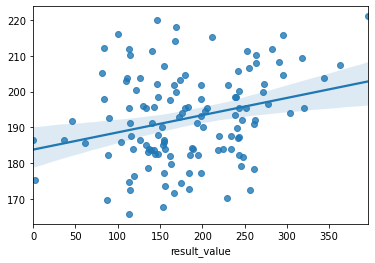

In [83]:
import seaborn as sns
sns.regplot(y_test,predictions)

###***Visualizing Relationship between length_of_stay (discharge date and time minus admission date and time) and charlson_comorbidity_index***

In [97]:
print(combined_df['charlson_comorbidity_index'].unique())
combined_df_plot = combined_df.copy()
combined_df_plot = combined_df_plot.dropna()
print(combined_df_plot['charlson_comorbidity_index'].unique())
print(combined_df_plot.shape)

['1' '0' nan '2+']
['0' '1' '2+']
(365, 24)


In [112]:
combined_df_plot['ddt'] = (combined_df_plot['discharge_date'] + " " + combined_df_plot['discharge_time']).astype('datetime64[ns]')
combined_df_plot['adt'] = (combined_df_plot['admission_date'] + " "+ combined_df_plot['admission_time']).astype('datetime64[ns]')
combined_df_plot['diff'] = (combined_df_plot['ddt'] - combined_df_plot['adt'])/ np.timedelta64(1, 'D')


In [133]:
combined_plot_grouped = combined_df_plot.groupby(['charlson_comorbidity_index']).mean().reset_index()

pandas.core.frame.DataFrame

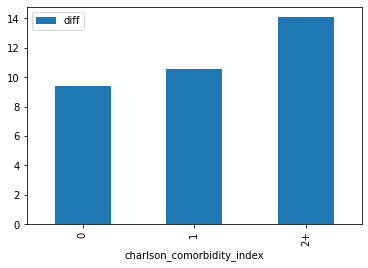

In [134]:
combined_plot_grouped.plot(x="charlson_comorbidity_index", y=["diff"], kind="bar")